# Data Wrangle OpenStreetMaps Data

## The data
We choose the OpenStreetMaps data of the Greater London area. The data is downloaded from [MapZen.com](https://mapzen.com/data/metro-extracts). To run the codes, download and decompress this [osm file](https://s3.amazonaws.com/metro-extracts.mapzen.com/london_england.osm.bz2), and move it into the folder [./osm data/](./osm data/).
## Lesson 6 problems
The code and input files of Lesson 6 problems are in [L6 problems](./L6 problems/) folder.
## Problems encountered in this map
### Conflicts of tag names
To parse the osm data into JSON, we have two default field names ```type``` and ```address```, then we add every second level tag "k" value as the new field name. However, some second level tags "k" have values ```type``` and ```address``` and cause erros of importing the data. To resolve this, we add the following codes into the ```shape_element(element)``` in ```parse_osm_data.py``` to add a suffix ```_tag``` if the the tag "k" has values ```type``` or ```address```:
```python
if atrb=="address" or atrb=="type":
    atrb=atrb+"_tag"
```

### Wrangling the feature "network"
Rail stations or bus stops in this data have a tag ```network``` to specify which transportation network that the station belongs to. For instance, an London Underground station has a tag that looks like this:
```xml
<tag k="network" v="London Underground"/>
```
Some stations serve two or more transportation network, the second level tag ```v``` will then have more than one values separated by ```;```. For example:
```xml
<tag k="network" v="National Rail;London Underground"/>
```
As a result, we have to parse the second level tag ```v``` into an array in order to query the data easily. In the above example, the resulting JSON file becomes:
```json
{'network': ['National Rail', 'London Underground']}
```
The function that performs this conversion is ```parse_network_str``` in ```process_tags.py```.

### Validation of postcodes
Each UK postcode has two parts. The first part is the area codes, which represents a big area. The second part represents a small unit, such as a street or a building. Some rules of UK postcodes can be found in the following pages:

https://en.wikipedia.org/wiki/London_postal_district

https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom

We adopt the following rules to validate the postcodes in this data set:
1. Take the last three digit and check if it matches the regular expression ```[0-9][A-Z][A-Z]```. For instance, *2NP* is a valid code, while *23G* is not.
2. Validate the remaining postcode string by converting [these rules](https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Validation) to regular expression, which are summarized in the following table. In *Format* column, *A* indicates an alphabet and *9* indicates a number.

| Format | Regular expression of valid area codes|
| ------------- | ----------- |
| AA9A      |```WC[0-9][A-Z]```,```EC[1234][A-Z]```,```(NW1W)```,```SE1P```,```SW1[A-Z]```|
| A9A     | ```W1[ABCDEFGHJKPSTUW]```,```E1W```,```N1C```,```N1P```|
| A9 or A99|```[BEGLMNSW][0-9][0-9]*```|
|AA9 or AA99|```[ABCDEFGHIJKLMNOPRSTUWYZ][ABCDEFGHKLMNOPQRSTUVWXY][0-9][0-9]*)```|

These principles only provide "first order" filtering of UK postcodes. To completely verify each postcodes, assistance of UK postcodes database such as [Royal Mail PAF](http://www.royalmail.com/business/services/marketing/data-optimisation/paf) is required.

The function that does this conversion is ```validate_uk_postcodes``` in ```process_tags.py```.

## Overview of the Data
### The size of data:
- London_England.osm -- 2.31 GB
- London_England.osm.json -- 3.21 GB

Import the data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
# Enter "mongod --dbpath ~/MongoDBData/" in terminal to initiate MongoDB server
from pymongo import MongoClient
client = MongoClient()
db = client.osm

Number of documents in the collection:

In [2]:
total_doc=db.london.find().count()
print("%s documents are in the dataset"%total_doc)

11763955 documents are in the dataset


Print one document

In [3]:
db.london.find_one()

{'_id': ObjectId('55d2e5dabc0c4d129716066c'),
 'amenity': 'post_box',
 'box_type': 'lamp_box',
 'created': {'changeset': '5159524',
  'timestamp': '2010-07-07T15:54:28Z',
  'uid': '253958',
  'user': 'user_253958',
  'version': '3'},
 'id': '26',
 'pos': [51.93021, -0.274278],
 'ref': 'SG4 118',
 'type': 'node'}

### Number of nodes and ways
Number of ```nodes```

In [4]:
db.london.find({"type":"node"}).count()

10311851

Number of ```way```

In [5]:
db.london.find({"type":"way"}).count()

1452104

In [6]:
db.london.distinct("type")

['node', 'way']

In [7]:
total_named_doc=db.london.find({"name":{"$exists":1}}).count()
print("%s documents have names."%total_named_doc)
print("That is, only %s%% of documents have names."%(total_named_doc/total_doc*100))

468780 documents have names.
That is, only 3.9848843352426973% of documents have names.


### Analysis of users who contributed to the map

Number of unique users contributing to the map

In [8]:
len(db.london.distinct("created.uid"))

7756

Find the top 10 contributing users

In [9]:
results=db.london.aggregate([{"$group":{"_id":"$created.user","count":{"$sum":1}}},\
                        {"$sort":{"count":-1}}])
output_lim=10
i=0
for r in results:
    i+=1
    if i<output_lim:
        print(r)
    else:
        break

{'_id': 'TimSC_Data_CC0_To_Andy_Allan', 'count': 469837}
{'_id': 'The Maarssen Mapper', 'count': 467799}
{'_id': 'Eriks Zelenka', 'count': 455467}
{'_id': 'busdoc', 'count': 359380}
{'_id': 'ca_hoot', 'count': 357349}
{'_id': 'Johnmb', 'count': 314722}
{'_id': 'Essex_Boy', 'count': 281843}
{'_id': 'c2r', 'count': 231340}
{'_id': 'Rondon237', 'count': 207332}


Plot the histogram of contributions of each unique users

(0, 1000)

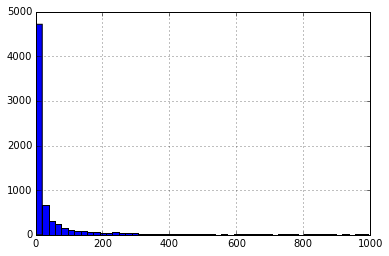

In [10]:
df=pd.DataFrame(list(results))
fig, ax = plt.subplots()
df["count"].hist(ax=ax,bins=10000)
ax.set_yscale("linear")
ax.set_xlim([0,1000])

### Analysis of postcodes
Find the top 10 areas with valid postcodes nodes

In [11]:
dd=db.london.aggregate([{"$match":{"address.postcode_area":{"$exists":1}}},
                        {"$group":{"_id":"$address.postcode_area","count":{"$sum":1}}},
                       {"$sort":{"count":-1}},
                       {"$limit": 10}])
for ddd in dd:
    print(ddd)

{'_id': 'NA', 'count': 351}
{'_id': 'TN31', 'count': 304}
{'_id': 'SW11', 'count': 61}
{'_id': 'RH10', 'count': 52}
{'_id': 'HA1', 'count': 39}
{'_id': 'NW6', 'count': 31}
{'_id': 'CR0', 'count': 29}
{'_id': 'E18', 'count': 27}
{'_id': 'N1', 'count': 25}
{'_id': 'SE1', 'count': 23}


Shows top 10 amenities

In [12]:
results=db.london.aggregate([{"$match":{"amenity":{"$exists":1}}},
                    {"$group":{"_id":"$amenity","count":{"$sum":1}}},
                    {"$sort":{"count":-1}},
                             {"$limit":10}])
for r in results:
    print(r)

{'_id': 'parking', 'count': 17318}
{'_id': 'post_box', 'count': 12653}
{'_id': 'pub', 'count': 7329}
{'_id': 'school', 'count': 6092}
{'_id': 'place_of_worship', 'count': 5817}
{'_id': 'restaurant', 'count': 5797}
{'_id': 'bicycle_parking', 'count': 5317}
{'_id': 'bench', 'count': 5244}
{'_id': 'cafe', 'count': 4178}
{'_id': 'telephone', 'count': 3729}


Group the data by postcode area and amenties, and show the top ten counts.

In [13]:
results=db.london.aggregate([{"$match":{"amenity":{"$exists":1},"address.postcode_area":{"$exists":1}}},
                    {"$group":{"_id":{"amenity":"$amenity","area":"$address.postcode_area"},"count":{"$sum":1}}},
                    {"$sort":{"count":-1}},
                             {"$limit":10}])
for r in results:
    print(r)

{'_id': {'amenity': 'post_box', 'area': 'NA'}, 'count': 24}
{'_id': {'amenity': 'cafe', 'area': 'CR0'}, 'count': 8}
{'_id': {'amenity': 'pub', 'area': 'GU28'}, 'count': 5}
{'_id': {'amenity': 'school', 'area': 'N16'}, 'count': 5}
{'_id': {'amenity': 'restaurant', 'area': 'SE1'}, 'count': 4}
{'_id': {'amenity': 'place_of_worship', 'area': 'GU26'}, 'count': 4}
{'_id': {'amenity': 'school', 'area': 'NA'}, 'count': 4}
{'_id': {'amenity': 'place_of_worship', 'area': 'SE1'}, 'count': 3}
{'_id': {'amenity': 'restaurant', 'area': 'TN1'}, 'count': 3}
{'_id': {'amenity': 'kindergarten', 'area': 'CR0'}, 'count': 3}


### Analysis of rail or underground stations

Find the total number of London underground stations

In [14]:
db.london.find({"network":{"$in":["London Underground"]},"railway":"station"}).count()

300

Find all stations which provide both *London Underground* and *National Rail* services

In [15]:
results=db.london.find({"network":{"$all":["National Rail","London Underground"]},
                "railway":"station"},{"_id":0,"name":1})
print("%s stations that these two networks."%results.count())

44 stations that these two networks.


Find all stations that provides *National Rail*, *London Underground* and *London Overground* services

In [16]:
results=db.london.find({"network":{"$all":["National Rail","London Underground","London Overground"]},
                "railway":"station"},{"_id":0,"name":1})
print("%s stations have these three networks."%results.count())

12 stations have these three networks.


Find all the rail stations in London that have four different networks:

In [17]:
results=db.london.find({"network":{"$size":4},"railway":"station"},{"_id":0,"name":1})
print(results.count())
for r in results:
    print(r)

1
{'name': 'London Liverpool Street'}


Find the railway station that has the largest number of networks:

In [18]:
dd=db.london.aggregate([{"$match":{"railway":"station","name":{"$exists":1},"network":{"$exists":1}}},
                        {"$project":{"_id":0,"name":1,"network_num":{"$size":"$network"},"network":1}},
                      {"$sort":{"network_num":-1}},
                       {"$limit":1}])
for ddd in dd:
    print(ddd)

{'name': 'Stratford', 'network': ['National Rail', 'London Underground', 'London Overground', 'TfL Rail', 'DLR'], 'network_num': 5}


## Other ideas about the dataset
### Filtering the OSM file before converting it to JSON
Although this dataset contains more than 10 million data entries, only very small portion of the data were given names and further edited. If these "unedited" data entries are not of interest, we can filter out these entries when converting the OSM file to JSON to save the computational resources of querying the database. However, ignoring these nodes causes errors in some statistical results such as the calculating the contributions of each unique users or how many nodes in a given area.
### Using third-party datasets to validate or fill in missing data
Large amount of data entries either miss addresses or contains inaccurate address information. This can be corrected by some third-party datasets or APIs such as [Royal Mail PAF](http://www.royalmail.com/business/services/marketing/data-optimisation/paf) or other [open data APIs](http://data.gov.uk/apps/uk-postcodes). These APIs allows UK address look up by entering GIS coordinates, which are in every entries of OSM data. Also, the information of the rail, bus and underground stations may be incomplete or incorrect. This can potentially be cleaned by using the [official API](https://api.tfl.gov.uk) provided by Tfl.
However, using these open data APIs to validate the data increases the time required to preprocess the data. A complete process of this validation methods includes sending a http request and parsing the returned data. If it takes 10 ms to complete this process for a single node, we still need about 32 hours to validate all the nodes. It would take even longer if the server or the network is busy. 